<a href="https://colab.research.google.com/github/oimartin/MNIST_Digit_Recognizer/blob/main/digits_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Models
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Model Fit Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.metrics import roc_curve

## First View of Data

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/train.zip')
test = pd.read_csv('https://raw.githubusercontent.com/oimartin/MNIST_Digit_Recognizer/main/data/test.zip')

display(train.shape, test.shape)

(42000, 785)

(28000, 784)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

### Explore Label Column

In [5]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

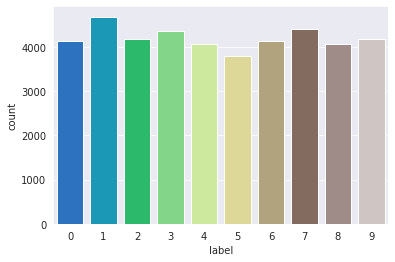

In [6]:
sns.set_style("darkgrid")
sns.countplot(data=train, x='label', palette='terrain')

### Missing Values

In [7]:
def null_sum (df):
  # double check for missing values
  nulls = df.isnull().sum()
  return nulls[nulls >=1]

In [8]:
null_sum(train)

Series([], dtype: int64)

In [9]:
null_sum(test)

Series([], dtype: int64)

## Split Data

In [10]:
# Inspired by Ben Hamner Random Forest Proximity Notebook:
# https://www.kaggle.com/benhamner/rf-proximity

# Create subset of train data to run faster
mini_train = train.iloc[:1000, :]
labels = mini_train.label.astype('category')
mini_train = mini_train.drop(columns='label')

In [11]:
X_train, X_test, labels_train, labels_test = train_test_split(mini_train,
                                                              labels,
                                                              test_size=0.2,
                                                              random_state=22)

print(f'''X_train shape {X_train.shape}
labels_train shape {labels_train.shape}
X_test shape {X_test.shape}
labels_test {labels_test.shape}
''')

X_train shape (800, 784)
labels_train shape (800,)
X_test shape (200, 784)
labels_test (200,)



# Model

## Model Functions

In [50]:
def run_model (model, model_name, x_data, y_data, gridcv=False,params=None):
  if gridcv is True:
    clf = GridSearchCV(model,params)
    start = time()
    fitted_model = clf.fit(x_data, y_data)
    end = time()
    runtime = round((end - start),4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")

  elif gridcv is False:
    start = time()
    fitted_model = model.fit(x_data, y_data)
    end = time()
    runtime = round((end-start), 4)
    print(f"{model_name} took {runtime} seconds or {round((runtime/60),4)} minutes to run.")
  return fitted_model, runtime

def submitted (prediction):
  df = pd.DataFrame(prediction).rename(columns={0: 'label'})
  df.index += 1
  df['ImageId'] = df.index
  return df

def prediction (fitted_model, x_feat):
  pred = fitted_model.predict(x_feat)
  return pred

def probability (fitted_model, x_feat):
  total_prob = fitted_model.predict_proba(x_feat)
  return total_prob

def evaluating_model (y_true, y_pred, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name, 
                                   model_name, model_name],
                   'type': [train_test, train_test,
                            train_test, train_test],
                   'metric_name': ["accuracy","f1",'recall',
                                   'precision'],
                   'metric' : [round(accuracy_score(y_true, y_pred),4),
                               round(f1_score(y_true, y_pred, average='micro'),4),
                               round(recall_score(y_true, y_pred, average='micro'), 4),
                               round(precision_score(y_true, y_pred, average='micro'), 4)]})
  display(df)
  return df

def prob_eval (y_true, y_prob, model_name, train_test):
  df=pd.DataFrame({ 'model_name': [model_name, model_name],
                   'type': [train_test, train_test],
                   'metric_name': ['log_loss','roc_auc'],
                   'metric' : [round(log_loss(y_true, y_prob), 4),
                               round(roc_auc_score(y_true, y_prob, multi_class='ovo'),4)]})
  display(df)
  return df


def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
  print(f'''
  {model_name} for {train_test} Data
  FPR {fpr}
  TPR {tpr}
  ''')
  return


## Random Forest Classifier

In [51]:
RFC_model, RFC_rt = run_model(RandomForestClassifier(), 'RFC', 
                              mini_train, labels, False)

train_pred_RFC = prediction(RFC_model, X_train)
train_totprob_RFC = probability(RFC_model, X_train)

test_pred_RFC = prediction(RFC_model, X_test)
test_totprob_RFC = probability(RFC_model, X_test)

RFC took 0.9942 seconds or 0.0166 minutes to run.


### RFC Evaluation

In [31]:
RFC_train = evaluating_model(labels_train, train_pred_RFC, 'RFC', 'Train')
RFC_train_prob = prob_eval(labels_train, train_totprob_RFC, 'RFC', 'Train')
eval_classification(train_pred_RFC, labels_train, X_train, 'RFC', 'Train')

print("---------------------")
RFC_test = evaluating_model(labels_test, test_pred_RFC, 'LG', 'Test')
RFC_test_prob = prob_eval(labels_test, test_totprob_RFC, 'LG', 'Test')
eval_classification(test_pred_RFC, labels_test, X_test, 'LG', 'Test')

,model_name,type,metric_name,metric
0,RFC,Train,accuracy,1.0
1,RFC,Train,f1,1.0
2,RFC,Train,recall,1.0
3,RFC,Train,precision,1.0


,model_name,type,metric_name,metric
0,RFC,Train,log_loss,0.1822
1,RFC,Train,roc_auc,1.0000



  RFC for Train Data
  FPR [0.         0.11080332 0.20775623 0.32409972 0.43351801 0.53739612
 0.6468144  0.74792244 0.88642659 0.88642659 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  
---------------------


,model_name,type,metric_name,metric
0,LG,Test,accuracy,1.0
1,LG,Test,f1,1.0
2,LG,Test,recall,1.0
3,LG,Test,precision,1.0


,model_name,type,metric_name,metric
0,LG,Test,log_loss,0.1827
1,LG,Test,roc_auc,1.0000



  LG for Test Data
  FPR [0.         0.09340659 0.21978022 0.33516484 0.43406593 0.51098901
 0.63736264 0.73076923 0.86263736 0.86263736 1.        ]
  TPR [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  


## RFC with GridCV

In [53]:
parameters = {'n_estimators':[50,100,200,400],
              'criterion': ('gini', 'entropy'),
              'min_samples_split': [1,2,3],
              'random_state': [22]}

RFCcv_model, RFCcv_rt = run_model(RandomForestClassifier(),'RFCcv',
                                  X_train,
                                  labels_train, 
                                  True,
                                  parameters)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

RFCcv took 99.3876 seconds or 1.6565 minutes to run.


### RFC with GridCV Evaluation